# Synthetic Data Fit

In [1]:
from drdmannturb.calibration import CalibrationProblem
from drdmannturb.data_generator import OnePointSpectraDataGenerator
from drdmannturb.shared.parameters import NNParameters, ProblemParameters, LossParameters, PhysicalParameters

import torch
import torch.nn as nn
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu" 

# v2: torch.set_default_device('cuda:0')
if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

L = 0.59

Gamma = 3.9
sigma = 3.4

domain = torch.logspace(-1, 2, 20)

In [2]:
pb = CalibrationProblem(
    nn_params = NNParameters(
        activations = [nn.GELU(), nn.GELU()], 
    ),
    prob_params = ProblemParameters(nepochs=5),
    loss_params = LossParameters(),
    phys_params = PhysicalParameters(
        L=L,
        Gamma=Gamma,
        sigma=sigma,
        domain=domain
    ), 
    device=device
)

In [3]:
parameters = pb.parameters
parameters[:3] = [
    np.log(L),
    np.log(Gamma),
    np.log(sigma)
]

pb.parameters = parameters[:len(pb.parameters)]

k1_data_pts = domain
DataPoints = [(k1, 1) for k1 in k1_data_pts]

In [4]:
Data = OnePointSpectraDataGenerator(data_points=DataPoints).Data

In [5]:
pb.eval(k1_data_pts)
pb.calibrate(data=Data)


Calibrating MannNet...
torch.Size([80])
Initial loss:  0.1116449837737767

[Calibration.py -- calibrate]-> Epoch 0

loss  =  0.1116449837737767
loss  =  0.07162027697405386
loss  =  0.06580675544791245
loss  =  0.04093396361133594
loss  =  0.040858387142817885
loss  =  0.04021898084886181
loss  =  0.03972437997485119
loss  =  0.037516379372090194
loss  =  0.03750029068698091
loss  =  0.03736538117579185
loss  =  0.037201843897984366
loss  =  0.03643045209370295
loss  =  0.03623209952051133
loss  =  0.03537714219642569
loss  =  0.03248778918631863
loss  =  0.03153982105599629
loss  =  0.03068972234005561
loss  =  0.02633276245612542
loss  =  0.03396511397819498
loss  =  0.02576866165602239
loss  =  0.025488277396080353
loss  =  0.023762540881251515
loss  =  0.02355339692554888
loss  =  0.023474471768493436
loss  =  0.023047628630683898
---------------------------------



[Calibration.py -- calibrate]-> Epoch 1

loss  =  0.023047628630683898
loss  =  0.02302752544875419
loss  =  0.0228

array([-4.28350510e-01,  1.07812066e+00,  1.02972771e+00, -2.29333301e-01,
        2.97387984e-01,  1.75832672e-01,  1.19438507e+00, -8.17611159e-01,
       -1.01304083e-01,  7.58136052e-02, -5.64904194e-01, -2.15447336e-01,
       -7.99267104e-02, -6.81517698e-03, -1.55129701e-01,  1.36436567e+00,
       -1.66918871e+00,  2.92008704e-01,  1.04836515e+00, -1.23163357e+00,
        8.34143968e-01,  3.80232004e-01, -3.60138089e-01, -2.94672745e-01,
        4.51457030e-01, -5.46003622e-01, -5.63204929e-02,  5.62889319e-02,
       -5.55298123e-01, -3.66693475e-01, -2.73815216e-01, -1.87341810e-01,
       -4.32359756e-01, -2.05935878e-01,  1.11449987e+00, -1.19907356e-01,
        2.76266180e-03,  6.24462392e-01,  3.76912789e-01, -7.64763042e-03,
        3.30099777e-01, -2.29054624e-01, -7.51525394e-02, -3.01831722e-01,
       -2.44222669e-01, -1.68727697e-01,  6.61620944e-02, -3.00926537e-01,
       -2.12813988e-01, -3.05124463e-01,  1.10223061e-01,  4.62765463e-02,
        1.61733419e-01, -

k1.size: torch.Size([20])   self.kF_data_vals: torch.Size([80])


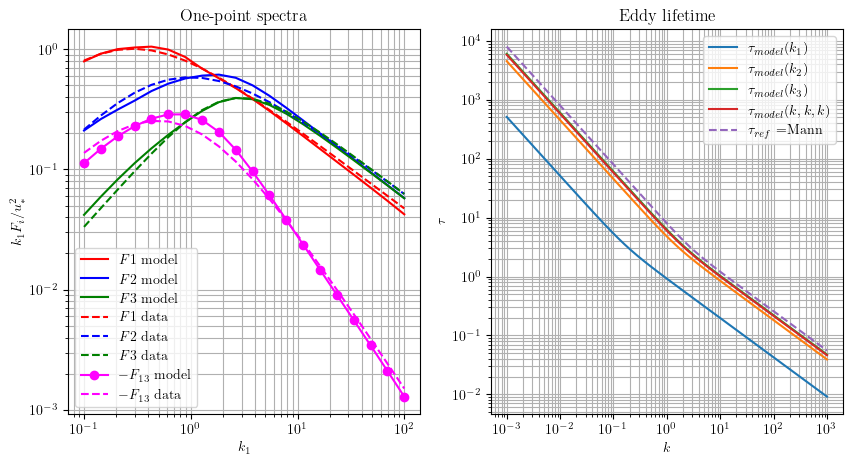

In [6]:
pb.plot(plt_dynamic=False)

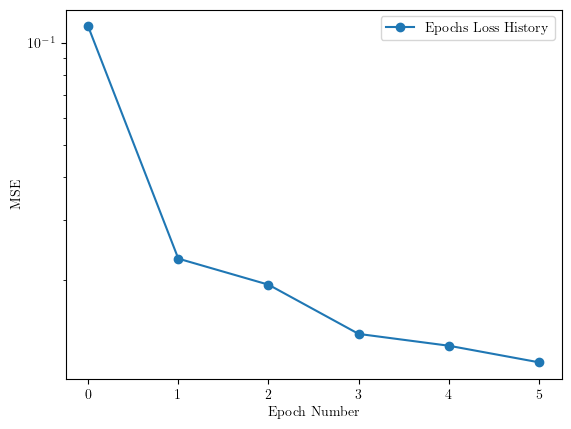

In [7]:
import matplotlib.pyplot as plt

plt.figure()

plt.plot( pb.loss_history_epochs, 'o-', label="Epochs Loss History")
plt.legend()
plt.xlabel("Epoch Number")
plt.ylabel("MSE")
plt.yscale('log')

plt.show()


## Save Model with Problem Metadata

In [8]:
pb.save_model()

## Loading Model and Problem Metadata

In [9]:
import pickle
path_to_parameters = "./results/EddyLifetimeType.CUSTOMMLP_DataType.KAIMAL.pkl"

with open(path_to_parameters, 'rb') as file: 
    nn_params, prob_params, loss_params, phys_params, model_params, loss_history_total, loss_history_epochs = pickle.load(file)

### Recovering Old Model Configuration and Old Parameters

In [14]:
pb_new = CalibrationProblem(nn_params=nn_params, prob_params=prob_params, loss_params=loss_params, phys_params=phys_params, device=device)

pb_new.parameters = model_params

assert (pb.parameters == pb_new.parameters).all()